In [5]:
from statsforecast.models import AutoARIMA
from statsforecast import StatsForecast
from hierarchicalforecast.methods import BottomUp, MinTrace
from hierarchicalforecast.utils import HierarchicalPlot

import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns 
sns.set_theme('notebook', 'white')

tags = pd.read_pickle('./tags.pkl')

In [3]:
df = pd.read_parquet('./loans_full_hierarchy.parquet')
df['date'] = df.index
Y_df = df.melt(id_vars='date')[['unique_id', 'date' ,'value']].rename(columns={'date' : 'ds', 'value' : 'y'})
Y_df.ds = pd.to_datetime(Y_df.ds)

reconcilers = [
            BottomUp(),
            MinTrace(method='mint_shrink')
        ]
levels = [80.]
models = [AutoARIMA(season_length=12)]
sf = StatsForecast(models, '1ME')

Y_test_df = Y_df.groupby('unique_id', as_index=False).tail(24)
Y_train_df = Y_df.drop(Y_test_df.index)

Y_pred = sf.forecast(df=Y_train_df, h=12, fitted=True, level = [80.])
# Y_fitted_df = sf.forecast_fitted_values()

/tmp/ipykernel_237205/3180028636.py:10: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  for item in leg.legendHandles:


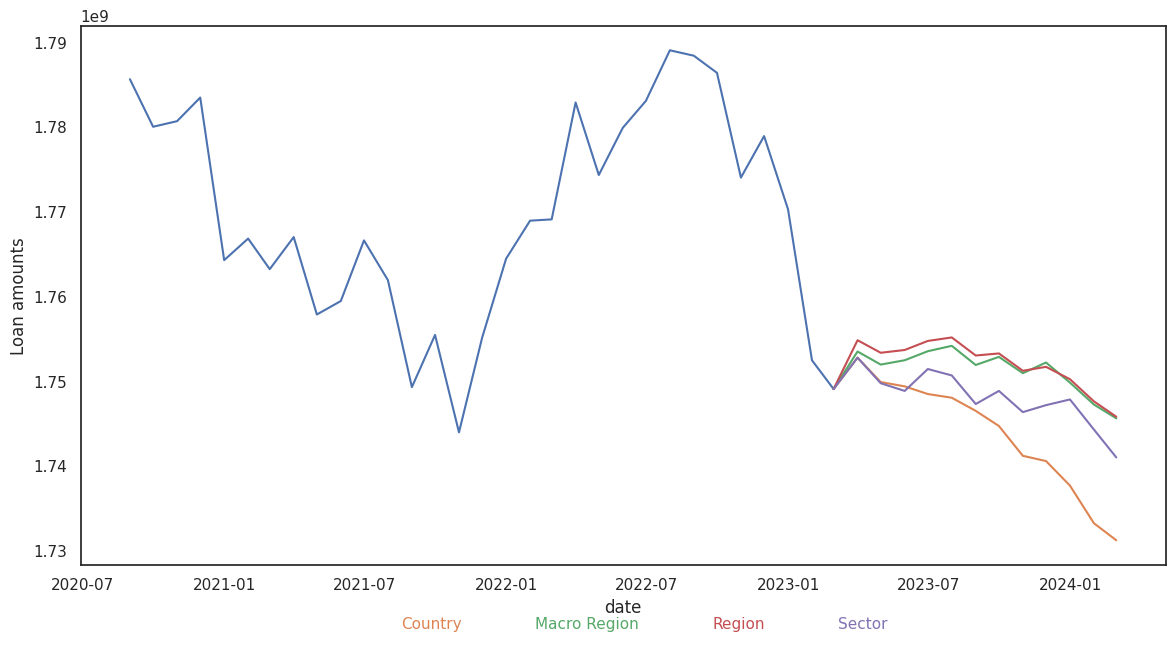

In [6]:
sns.set_theme('notebook', 'white')
fig, ax = plt.subplots(1,1, figsize = (14,7))
train = Y_train_df.query('unique_id == "IT"').iloc[110:,:]
ax.plot(train.ds, train.y)
for a in tags.items() : 
    pred = Y_pred.query('unique_id in @a[1]').groupby('ds').sum()
    ax.plot( [list(train.ds)[-1]]+list(pred.index),[list(train.y)[-1]]+list(pred.AutoARIMA), label = a[0].split('/')[-1])
    ax.legend()
leg = plt.legend(['Country', 'Macro Region', 'Region', 'Sector'], loc='lower center', bbox_to_anchor=(0.5, -0.15), ncol = 4, frameon = False)
for item in leg.legendHandles:
    item.set_visible(False)
c = ['C1', 'C2', 'C3', 'C4']
for i,text in enumerate(leg.get_texts()) :
    text.set_color(c[i])
    # text.set_size(15)
ax.set_xlabel('date')
ax.set_ylabel('Loan amounts')
plt.savefig('forecast_incosistency', dpi = 200, transparent = True, bbox_inches = 'tight')
